In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from pypfopt import black_litterman
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, EfficientFrontier, expected_returns
import pandas as pd
import joblib  # For saving and loading scalers
import matplotlib.pyplot as plt  # For plotting
from tensorflow.keras.models import Sequential, load_model
import warnings
warnings.filterwarnings("ignore")

In [2]:
risk_free_rate = 0.065  # Risk free rate

In [3]:
# data = pd.read_csv("Top_4_stocks.csv")
# data["Date"] = pd.to_datetime(data['Date'])
# data.set_index("Date", inplace=True)
# data.head(10)

mcap = pd.read_csv("mcap.csv", index_col=0)
mcap.index = pd.to_datetime(mcap.index)

data = pd.read_csv('prices.csv', index_col=0)
data.index = pd.to_datetime(data.index)

data.head()

,NTPC,PWGR,TCS,WPRO,DLFU,GCPL,LT,SIEM,SUNP,CIPLA,HDFCB,ICICIBC,RELIANCE,ONGC,HUVR,ITC,BHARTI,IDEA,SAIL,HNDL
Date,,,,,,,,,,,,,,,,,,,,
2015-01-01,118.71,77.12,1272.78,103.58,137.40,321.97,1001.97,906.70,822.20,628.40,476.03,320.27,200.33,229.37,758.45,231.55,327.07,96.25,82.75,158.45
2015-01-02,120.33,78.05,1289.72,104.49,139.20,323.37,1023.10,914.35,826.25,630.15,482.65,329.36,199.80,232.80,755.95,232.28,329.00,96.58,82.85,160.10
2015-01-05,120.00,78.13,1270.13,104.68,135.80,323.48,1037.33,918.65,826.75,633.00,478.58,330.05,197.61,235.43,760.30,233.19,321.70,92.74,82.70,156.85
2015-01-06,116.00,76.39,1223.30,102.23,133.65,317.33,1002.73,895.70,808.55,614.35,471.13,316.05,188.64,222.10,774.70,227.20,319.18,90.90,78.65,153.40
2015-01-07,118.79,77.48,1208.85,101.46,134.60,320.05,1000.33,899.20,809.80,611.95,472.50,307.50,192.75,225.37,801.90,222.98,319.95,90.45,77.80,148.90


In [ ]:
cols = data.columns.tolist()
data = data[cols]
mcap = mcap[cols]

In [155]:
mcap.loc[pd.to_datetime("2018-01-08")].to_dict()

{'NTPC': 1464806.6906,
 'PWGR': 1049195.2648,
 'TCS': 5196141.99,
 'WPRO': 1407520.7779,
 'DLFU': 464300.7916,
 'GCPL': 677718.4944,
 'LT': 1874930.5936,
 'SIEM': 460623.7438,
 'SUNP': 1419396.0687,
 'CIPLA': 495081.2242,
 'HDFCB': 4819184.0316,
 'ICICIBC': 2017569.2265,
 'RELIANCE': 5880974.6926}

In [5]:
assets = data.columns
assets

Index(['NTPC', 'PWGR', 'TCS', 'WPRO', 'DLFU', 'GCPL', 'LT', 'SIEM', 'SUNP',
       'CIPLA', 'HDFCB', 'ICICIBC', 'RELIANCE'],
      dtype='object')

In [6]:
def annualize_returns(returns, horizon=3):
    trading_days_per_year = 252
    annualized_returns = (1 + returns) ** (trading_days_per_year / horizon) - 1
    return annualized_returns

In [7]:
training_dates = []
testing_dates = []

start_date = data.index[0 + 3]
end_date = data.index[-1]

# Generate training and testing date ranges
while start_date + pd.DateOffset(years=4) <= end_date:
    training_dates.append((start_date, start_date + pd.DateOffset(years=3)))
    testing_dates.append((start_date + pd.DateOffset(years=3), start_date + pd.DateOffset(years=4)))
    start_date += pd.DateOffset(years=1)

In [8]:
training_dates, testing_dates

([(Timestamp('2015-01-06 00:00:00'), Timestamp('2018-01-06 00:00:00')),
  (Timestamp('2016-01-06 00:00:00'), Timestamp('2019-01-06 00:00:00')),
  (Timestamp('2017-01-06 00:00:00'), Timestamp('2020-01-06 00:00:00')),
  (Timestamp('2018-01-06 00:00:00'), Timestamp('2021-01-06 00:00:00')),
  (Timestamp('2019-01-06 00:00:00'), Timestamp('2022-01-06 00:00:00')),
  (Timestamp('2020-01-06 00:00:00'), Timestamp('2023-01-06 00:00:00')),
  (Timestamp('2021-01-06 00:00:00'), Timestamp('2024-01-06 00:00:00'))],
 [(Timestamp('2018-01-06 00:00:00'), Timestamp('2019-01-06 00:00:00')),
  (Timestamp('2019-01-06 00:00:00'), Timestamp('2020-01-06 00:00:00')),
  (Timestamp('2020-01-06 00:00:00'), Timestamp('2021-01-06 00:00:00')),
  (Timestamp('2021-01-06 00:00:00'), Timestamp('2022-01-06 00:00:00')),
  (Timestamp('2022-01-06 00:00:00'), Timestamp('2023-01-06 00:00:00')),
  (Timestamp('2023-01-06 00:00:00'), Timestamp('2024-01-06 00:00:00')),
  (Timestamp('2024-01-06 00:00:00'), Timestamp('2025-01-06 00:0

In [9]:
t1 = pd.Timestamp("2024-03-11 10:30:00")
t2 = pd.Timestamp("2025-03-18 15:45:00")

def get_model_name(stock_name, idx):
    model_name = f"{stock_name}_{training_dates[idx][0].strftime('%Y%m%d')}_{training_dates[idx][1].strftime('%Y%m%d')}"
    print(model_name)
    return model_name

get_model_name(assets[1],0)

PWGR_20150106_20180106


'PWGR_20150106_20180106'

In [161]:
[d[1] for d in testing_dates]

[Timestamp('2019-01-06 00:00:00'),
 Timestamp('2020-01-06 00:00:00'),
 Timestamp('2021-01-06 00:00:00'),
 Timestamp('2022-01-06 00:00:00'),
 Timestamp('2023-01-06 00:00:00'),
 Timestamp('2024-01-06 00:00:00'),
 Timestamp('2025-01-06 00:00:00')]

In [ ]:
import scipy.optimize as sco  # Import scipy.optimize as sco

def min_volatility_weights(mu, S):
    ef = EfficientFrontier(mu, S, weight_bounds=(0.0, 0.5))
    ef.min_volatility()
    cleaned_weights = ef.clean_weights()
    return cleaned_weights


def max_sharpe_ratio(mu, S):

    num_assets = len(mu)

    def sharpe_ratio(weights):
        weights = np.array(weights)
        port_return = np.dot(weights, mu)
        port_volatility = np.sqrt(np.dot(weights.T, np.dot(S, weights)))
        return -(port_return - risk_free_rate) / port_volatility  # Negative for minimization

    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})  # Sum of weights must be 1
    bounds = tuple((0.0,0.50) for _ in range(num_assets))  # No short selling
    initial_weights = np.ones(num_assets) / num_assets  # Equal allocation start

    result = sco.minimize(sharpe_ratio, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints, options={'disp': False, 'maxiter': 1000})

    optimal_weights = result.x
    cleaned_weights = {asset: weight for asset, weight in zip(data.columns, optimal_weights)}
    return cleaned_weights

import cvxpy as cp
def MVO(bl_returns, bl_cov):
    # Convert bl_returns to a NumPy array to ensure compatibility with cvxpy
    bl_returns = bl_returns.to_numpy()
    
    n = len(bl_returns)
    w = cp.Variable(n)

    # Objective function: w^T mu - lambda * w^T S w
    lambda_val = 3  # Risk aversion parameter (balanced approach)
    portfolio_return = bl_returns @ w  # Now using matrix multiplication with NumPy array
    portfolio_variance = cp.quad_form(w, bl_cov)
    objective = cp.Maximize(portfolio_return - lambda_val * portfolio_variance)

    # Constraints
    constraints = [
        cp.sum(w) == 1,  # Weights sum to 1
        w >= 0.00,
        w <= 0.50,  # Long-only constraint
            # Long-only constraint
    ]

    # Step 2: Define and solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Step 3: Extract the optimal weights
    optimal_weights = w.value
    if optimal_weights is None:
        raise ValueError("Optimization failed to find a solution.")

    optimal_weights = np.round(optimal_weights, decimals=4)
    optimal_weights = np.maximum(optimal_weights, 0)

    weights_dict = dict(zip(assets, optimal_weights))
    return weights_dict


In [11]:
def backtest(strategy):
    start_date = pd.to_datetime("2018-01-08")
    end_date = pd.to_datetime("2025-01-08")

    initial_weights = {ticker: 1/len(assets) for ticker in assets}  # Equal weights
    mcaps_dict = mcap.loc[start_date].to_dict()

    initial_investment = 100  # Initial portfolio value
    portfolio_value = [initial_investment]
    dates = [start_date]

    model_change_dates = [d[1] for d in testing_dates]  # All the dates when the model changes
    model_number = 0

    rebalance_frequency = 3  # Rebalancing frequency (e.g., every 3 days)
    transaction_cost_rate = 0.004  # 0.4% transaction cost

    # Initial model for each asset
    model_dict = {}
    for asset in assets:
        model_name = get_model_name(asset, model_number)
        model = load_model(f"models/{model_name}.h5")
        scaler = joblib.load(f"models/{model_name}_scaler.pkl")
        model_dict[asset] = [model, scaler]

    # List to store weights
    W = []

    # Backtest loop
    current_date = start_date
    last_rebalance_date = start_date
    previous_weights = None

    while current_date < end_date:
        # Prepare input data for LSTM predictions
        Q = {}
        for stock_name, (model, scaler) in model_dict.items():
            input_data = data.loc[:current_date, stock_name].tail(30).values.reshape(-1, 1)
            scaled_input_data = scaler.transform(input_data)
            scaled_predicted_returns = model.predict(scaled_input_data.reshape(1, 30, 1), verbose=0)
            predicted_returns = scaler.inverse_transform(scaled_predicted_returns)[0]
            predicted_returns = predicted_returns[0] * (252/3) * (1/15)
            Q[stock_name] = predicted_returns

        # View dictionary for Black-Litterman
        viewdict = Q
        
        # Covariance matrix (S)
        S = risk_models.sample_cov(data.loc[:current_date])

        # Risk aversion parameter
        delta = black_litterman.market_implied_risk_aversion(data.loc[:current_date])

        # Market-implied prior returns
        prior = black_litterman.market_implied_prior_returns(mcap.loc[start_date].to_dict(), delta, S)
        
        # Black-Litterman model
        bl = BlackLittermanModel(S, pi=prior, absolute_views=viewdict)
        bl_returns = bl.bl_returns()
        bl_cov = bl.bl_cov()

        # Portfolio optimization
        cleaned_weights = strategy(bl_returns, bl_cov)  # Use provided strategy (e.g., max_sharpe_ratio)

        # Check rebalancing conditions
        should_rebalance = False
        days_since_rebalance = (current_date - last_rebalance_date).days
        
        if days_since_rebalance >= rebalance_frequency:
            should_rebalance = True
        
        if previous_weights is not None:
            weight_diff = sum(abs(cleaned_weights.get(stock, 0) - previous_weights.get(stock, 0)) 
                            for stock in set(cleaned_weights.keys()) | set(previous_weights.keys()))
            if weight_diff >= 0.6:  # 60% threshold
                should_rebalance = True

        if should_rebalance:
            W.append(cleaned_weights)
            
            # Calculate transaction costs
            if previous_weights is not None:
                turnover = sum(abs(cleaned_weights.get(stock, 0) - previous_weights.get(stock, 0)) 
                              for stock in set(cleaned_weights.keys()) | set(previous_weights.keys()))
                transaction_cost = portfolio_value[-1] * turnover * transaction_cost_rate
            else:
                transaction_cost = 0  # No cost on first allocation
            
            previous_weights = cleaned_weights.copy()
            last_rebalance_date = current_date
            
            # Compute portfolio returns for the next rebalance period
            curr_date_index = data.index.get_loc(current_date)
            next_index = min(curr_date_index + rebalance_frequency, len(data) - 1)
            next_date = data.index[next_index]

            # Get actual returns for the rebalance period
            actual_returns = data.loc[current_date:next_date].pct_change().dropna()

            # Ensure cleaned_weights is aligned correctly
            cleaned_weights_series = pd.Series(cleaned_weights)
            
            # Compute portfolio return and apply transaction cost
            portfolio_returns = (actual_returns @ cleaned_weights_series).values

            for j in range(len(portfolio_returns)):
                # Calculate new value before transaction cost
                new_value = portfolio_value[-1] * (1 + portfolio_returns[j])
                # Apply transaction cost only on the first day of rebalancing
                if j == 0 and transaction_cost > 0:
                    new_value -= transaction_cost
                portfolio_value.append(new_value)
                dates.append(actual_returns.index[j])  # Append correct date

            print(f"Portfolio value at {next_date}: {portfolio_value[-1]}")
            
            # Move to the next rebalance date
            current_date = next_date
        else:
            # Move forward one day if no rebalancing
            curr_date_index = data.index.get_loc(current_date)
            current_date = data.index[min(curr_date_index + 1, len(data) - 1)]

        # Model change logic
        if model_number < len(model_change_dates) and current_date >= model_change_dates[model_number]:
            model_number += 1
            try:
                for asset in assets:
                    model_name = get_model_name(asset, model_number)
                    model = load_model(f"models/{model_name}.h5")
                    scaler = joblib.load(f"models/{model_name}_scaler.pkl")
                    model_dict[asset] = [model, scaler]
            except Exception as e:
                print(f"Error loading new model: {e}")
                break

    # Final portfolio value
    print(f"Final portfolio value: {portfolio_value[-1]}")
    return portfolio_value, dates, W

In [190]:
portfolio_value_BL_MS, dates_BL_MS, W_BL_MS = backtest(max_sharpe_ratio)

NTPC_20150106_20180106
PWGR_20150106_20180106
TCS_20150106_20180106
WPRO_20150106_20180106
DLFU_20150106_20180106
GCPL_20150106_20180106
LT_20150106_20180106
SIEM_20150106_20180106
SUNP_20150106_20180106
CIPLA_20150106_20180106
HDFCB_20150106_20180106
ICICIBC_20150106_20180106
RELIANCE_20150106_20180106
Portfolio value at 2018-01-16 00:00:00: 100.2319651615335
Portfolio value at 2018-01-19 00:00:00: 101.2791872081681
Portfolio value at 2018-01-24 00:00:00: 102.67549560020957
Portfolio value at 2018-01-30 00:00:00: 101.62872970314113
Portfolio value at 2018-02-02 00:00:00: 99.5384996046217
Portfolio value at 2018-02-07 00:00:00: 95.93898001569174
Portfolio value at 2018-02-12 00:00:00: 98.35826354401932
Portfolio value at 2018-02-16 00:00:00: 98.10752488546628
Portfolio value at 2018-02-21 00:00:00: 96.8042528687895
Portfolio value at 2018-02-26 00:00:00: 95.51547052350305
Portfolio value at 2018-03-01 00:00:00: 94.23903956673838
Portfolio value at 2018-03-07 00:00:00: 90.92986951288984

In [209]:
portfolio_value_BL_MV, dates_BL_MV, W_BL_MV = backtest(min_volatility_weights)

NTPC_20150106_20180106
PWGR_20150106_20180106
TCS_20150106_20180106
WPRO_20150106_20180106
DLFU_20150106_20180106
GCPL_20150106_20180106
LT_20150106_20180106
SIEM_20150106_20180106
SUNP_20150106_20180106
CIPLA_20150106_20180106
HDFCB_20150106_20180106
ICICIBC_20150106_20180106
RELIANCE_20150106_20180106
Portfolio value at 2018-01-16 00:00:00: 101.0595757961232
Portfolio value at 2018-01-19 00:00:00: 102.50064606534188
Portfolio value at 2018-01-24 00:00:00: 103.68055127415373
Portfolio value at 2018-01-30 00:00:00: 103.23762386321017
Portfolio value at 2018-02-02 00:00:00: 100.86259288375342
Portfolio value at 2018-02-07 00:00:00: 97.9753654876895
Portfolio value at 2018-02-12 00:00:00: 99.2785638239894
Portfolio value at 2018-02-16 00:00:00: 98.71865275747702
Portfolio value at 2018-02-21 00:00:00: 98.44428639997524
Portfolio value at 2018-02-26 00:00:00: 99.54213205515201
Portfolio value at 2018-03-01 00:00:00: 98.84751621239674
Portfolio value at 2018-03-07 00:00:00: 96.898276142190

In [192]:
portfolio_value_BL_MVO, dates_BL_MVO, W_BL_MVO = backtest(MVO)

NTPC_20150106_20180106
PWGR_20150106_20180106
TCS_20150106_20180106
WPRO_20150106_20180106
DLFU_20150106_20180106
GCPL_20150106_20180106
LT_20150106_20180106
SIEM_20150106_20180106
SUNP_20150106_20180106
CIPLA_20150106_20180106
HDFCB_20150106_20180106
ICICIBC_20150106_20180106
RELIANCE_20150106_20180106
Portfolio value at 2018-01-16 00:00:00: 101.15977111713391
Portfolio value at 2018-01-19 00:00:00: 102.34514796811843
Portfolio value at 2018-01-24 00:00:00: 102.89598539119604
Portfolio value at 2018-01-30 00:00:00: 102.28267015185948
Portfolio value at 2018-02-02 00:00:00: 99.2589106313112
Portfolio value at 2018-02-07 00:00:00: 96.37656129282871
Portfolio value at 2018-02-12 00:00:00: 97.7543255762902
Portfolio value at 2018-02-16 00:00:00: 97.30308454382352
Portfolio value at 2018-02-21 00:00:00: 96.49899707736117
Portfolio value at 2018-02-26 00:00:00: 97.68477341208225
Portfolio value at 2018-03-01 00:00:00: 96.6168760024
Portfolio value at 2018-03-07 00:00:00: 94.20607769514527
P

In [12]:
def backtest_normal(strategy):
    start_date = pd.to_datetime("2018-01-08")
    end_date = pd.to_datetime("2025-01-08")

    initial_investment = 100  # Initial portfolio value
    portfolio_value = [initial_investment]
    dates = [start_date]

    rebalance_frequency = 3
    transaction_cost_rate = 0.004  # 0.4% transaction cost

    W = []                     

    # Backtest loop
    current_date = start_date
    last_rebalance_date = start_date
    previous_weights = None

    # Number of assets (to compute equal weights)
    n_assets = len(assets)
    equal_weight = 1.0 / n_assets  # Equal weight for each asset

    while current_date < end_date:
        S = risk_models.sample_cov(data.loc[:current_date])
        
        # Assign weights based on strategy
        if strategy == "ew":
            cleaned_weights = {stock: equal_weight for stock in assets}
        
        elif strategy == "ms":
            mu = expected_returns.mean_historical_return(data.loc[:current_date])
            cleaned_weights = max_sharpe_ratio(mu, S)
        
        elif strategy == "mv":
            mu = expected_returns.mean_historical_return(data.loc[:current_date])
            cleaned_weights = min_volatility_weights(mu, S)

        elif strategy == "mvo":
            S = risk_models.sample_cov(data.loc[:current_date])
            mu = expected_returns.mean_historical_return(data.loc[:current_date])
            cleaned_weights = MVO(mu, S)
            
        # Check rebalancing conditions
        should_rebalance = False
        days_since_rebalance = (current_date - last_rebalance_date).days
        
        # Condition 1: Every 3 days
        if days_since_rebalance >= rebalance_frequency:
            should_rebalance = True
        
        # Condition 2: Weights change by 60% or more
        if previous_weights is not None:
            weight_diff = sum(abs(cleaned_weights.get(stock, 0) - previous_weights.get(stock, 0)) 
                             for stock in set(cleaned_weights.keys()) | set(previous_weights.keys()))
            if weight_diff >= 0.6:  # 60% threshold
                should_rebalance = True

        if should_rebalance:
            W.append(cleaned_weights)
            
            # Calculate transaction costs
            if previous_weights is not None:
                turnover = sum(abs(cleaned_weights.get(stock, 0) - previous_weights.get(stock, 0)) 
                              for stock in set(cleaned_weights.keys()) | set(previous_weights.keys()))
                transaction_cost = portfolio_value[-1] * turnover * transaction_cost_rate
            else:
                transaction_cost = 0  # No cost on first allocation
            
            previous_weights = cleaned_weights.copy()
            last_rebalance_date = current_date
            
            # Compute portfolio returns for the next rebalance period
            curr_date_index = data.index.get_loc(current_date)
            next_index = min(curr_date_index + rebalance_frequency, len(data) - 1)
            next_date = data.index[next_index]

            # Get actual returns for the rebalance period
            actual_returns = data.loc[current_date:next_date].pct_change().dropna()

            # Ensure cleaned_weights is aligned correctly
            cleaned_weights_series = pd.Series(cleaned_weights)
            
            # Compute portfolio return and apply transaction cost
            portfolio_returns = (actual_returns @ cleaned_weights_series).values

            # Ensure equal length between portfolio_value and dates
            for j in range(len(portfolio_returns)):
                # Calculate new value before transaction cost
                new_value = portfolio_value[-1] * (1 + portfolio_returns[j])
                # Apply transaction cost only on the first day of rebalancing
                if j == 0 and transaction_cost > 0:
                    new_value -= transaction_cost
                portfolio_value.append(new_value)
                dates.append(actual_returns.index[j])  # Append correct date

            # print(f"Portfolio value at {next_date}: {portfolio_value[-1]}")
            
            # Move to the next rebalance date
            current_date = next_date
        else:
            # Move forward one day if no rebalancing
            curr_date_index = data.index.get_loc(current_date)
            current_date = data.index[min(curr_date_index + 1, len(data) - 1)]

    # Final portfolio value
    print(f"Final portfolio value: {portfolio_value[-1]}")
    
    return portfolio_value, dates, W

In [174]:
portfolio_value_normal_ew, dates_normal_ew, W_normal_ew = backtest_normal("ew")

Final portfolio value: 333.75337151695607


In [14]:
def min_volatility_weights(mu, S):
    ef = EfficientFrontier(mu, S, weight_bounds=(0.0, 0.5))
    ef.min_volatility()
    cleaned_weights = ef.clean_weights()
    return cleaned_weights

portfolio_value_normal_mv, dates_normal_mv, W_normal_mv = backtest_normal("mv")

Final portfolio value: 289.3305111909004


In [179]:
portfolio_value_normal_ms, dates_normal_ms, W_normal_ms = backtest_normal("ms")

Final portfolio value: 274.6583634508963


In [ ]:
import cvxpy as cp

portfolio_value_normal_mvo, dates_normal_mvo, W_normal_mvo = backtest_normal("mvo")

Final portfolio value: 236.24134890421695


In [83]:
risk_free_rate = 0.065  # Risk free rate
def get_annualized_returns(portfolio_value):
    return (portfolio_value[-1] / portfolio_value[0]) ** (252 / len(portfolio_value)) - 1

def get_sharpe_ratio(portfolio_value):
    annualized_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0]) ** (252 / len(portfolio_value)) - 1
    annualized_volatility = portfolio_value.pct_change().std() * np.sqrt(252)
    return (annualized_return - risk_free_rate) / annualized_volatility

def get_sortino_ratio(portfolio_value):
    annualized_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0]) ** (252 / len(portfolio_value)) - 1
    downside_volatility = portfolio_value.pct_change()[portfolio_value.pct_change() < 0].std() * np.sqrt(252)
    return (annualized_return - risk_free_rate) / downside_volatility

def get_max_drawdown(portfolio_value):
    drawdown =  []
    peak = portfolio_value[0]

    for i in range(len(portfolio_value)):
        if portfolio_value[i] >= peak:
            peak = portfolio_value[i]
            drawdown.append(0)
        else:
            drawdown.append((portfolio_value[i] - peak) / peak)
    
    return drawdown

def get_volatility(portfolio_value):
    return portfolio_value.pct_change().std() * np.sqrt(252)

def calculate_yearly_metrics(portfolio_values, dates):
    # Convert to DataFrame with dates as index
    df = pd.DataFrame({
        'portfolio_value': portfolio_values,
        'date': pd.to_datetime(dates)
    }).set_index('date')
    
    # Group by year
    yearly_groups = df.groupby(df.index.year)
    
    results = []
    
    for year, group in yearly_groups:
        if len(group) < 5:  # Skip partial years with insufficient data
            continue
            
        annual_return = get_annualized_returns(group['portfolio_value'])
        sharpe = get_sharpe_ratio(group['portfolio_value'])
        sortino = get_sortino_ratio(group['portfolio_value'])
        max_drawdown = min(get_max_drawdown(group['portfolio_value'])) * 100  # as percentage
        volatility = get_volatility(group['portfolio_value'])
        
        results.append({
            'Year': year,
            'Annual Return (%)': annual_return * 100,
            'Sharpe Ratio': sharpe,
            'Sortino Ratio': sortino,
            'Max Drawdown (%)': max_drawdown,
            'Volatility (%)': volatility * 100
        })
    
    return pd.DataFrame(results).set_index('Year')


In [170]:
import pandas as pd

# Read and prepare data
nifty50 = pd.read_csv("NIFTY_50_Index.csv")
nifty50["Date"] = pd.to_datetime(nifty50["Date"])
nifty50.set_index("Date", inplace=True)

# Filter date range first
nifty50 = nifty50.loc["2018-01-08":"2025-01-08"]
nifty50_dates = nifty50["2018-01-08":"2025-01-08"].index

# Calculate returns on specific column
nifty50_returns = nifty50['^NSEI'].pct_change().dropna()

# Initialize portfolio
nifty50_portfolio = [100]

# Calculate portfolio value
for i in range(len(nifty50_returns)):
    nifty50_portfolio.append(nifty50_portfolio[-1] * (1 + nifty50_returns.iloc[i]))

nifty50_portfolio[-1]




222.9842058227156

In [26]:
len(nifty50_portfolio), len(nifty50_dates)

(1725, 1725)

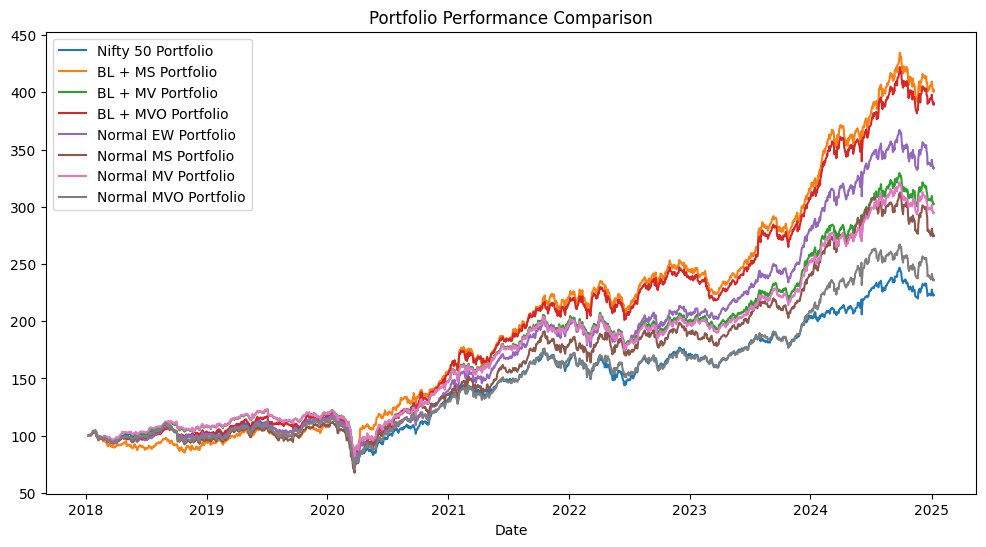

In [210]:
plt.figure(figsize=(12, 6))
plt.plot(nifty50_dates, nifty50_portfolio, label='Nifty 50 Portfolio')
plt.plot(dates_BL_MS, portfolio_value_BL_MS, label='BL + MS Portfolio')
plt.plot(dates_BL_MV, portfolio_value_BL_MV, label='BL + MV Portfolio')
plt.plot(dates_BL_MVO, portfolio_value_BL_MVO, label='BL + MVO Portfolio')
plt.plot(dates_normal_ew, portfolio_value_normal_ew, label='Normal EW Portfolio')
plt.plot(dates_normal_ms, portfolio_value_normal_ms, label='Normal MS Portfolio')
plt.plot(dates_normal_mv, portfolio_value_normal_mv, label='Normal MV Portfolio')
plt.plot(dates_normal_mvo, portfolio_value_normal_mvo, label='Normal MVO Portfolio')


plt.xlabel('Date')
plt.title('Portfolio Performance Comparison')
plt.legend()

In [211]:
# make a dataframe for metrics
metrics = pd.DataFrame(columns=["Sharpe Ratio", "Sortino Ratio", "Volatility"])
for i, portfolio in enumerate([nifty50_portfolio , portfolio_value_BL_MS, portfolio_value_BL_MVO, portfolio_value_BL_MV, portfolio_value_normal_ew, portfolio_value_normal_ms, portfolio_value_normal_mv, portfolio_value_normal_mvo]):
   # portfolio_name = ["Nifty 50","BL + MS Portfolio", "BL + MV Portfolio", "Normal EW Portfolio", "Normal MS Portfolio", "Normal MV Portfolio"][i]
    portfolio_name = ["Nifty 50","BL + MS Portfolio", "BL + MV Portfolio", "BL + MVO Portfolio", "Normal EW Portfolio", "Normal MS Portfolio", "Normal MV Portfolio", "Normal MVO Portfolio"][i]
    metrics.loc[portfolio_name, "Sharpe Ratio"] = get_sharpe_ratio(pd.Series(portfolio))
    metrics.loc[portfolio_name, "Sortino Ratio"] = get_sortino_ratio(pd.Series(portfolio))
    metrics.loc[portfolio_name, "Volatility"] = get_volatility(pd.Series(portfolio))
    metrics.loc[portfolio_name, "Annualized Returns"] = get_annualized_returns(portfolio)
    metrics.loc[portfolio_name, "Max Drawdown"] = min(get_max_drawdown(pd.Series(portfolio)))


# include nifty 50 portfolio in the metrics dataframe


metrics

,Sharpe Ratio,Sortino Ratio,Volatility,Annualized Returns,Max Drawdown
Nifty 50,0.363193,0.430397,0.177013,0.124290,-0.384399
BL + MS Portfolio,0.916473,1.231615,0.178708,0.223781,-0.316035
BL + MV Portfolio,0.953984,1.231261,0.166336,0.218682,-0.347433
BL + MVO Portfolio,0.732075,0.923989,0.156767,0.174765,-0.335145
Normal EW Portfolio,0.776371,0.946834,0.169599,0.191672,-0.364420
Normal MS Portfolio,0.525034,0.654768,0.187336,0.158358,-0.397528
Normal MV Portfolio,0.708165,0.898742,0.155786,0.170322,-0.334782
Normal MVO Portfolio,0.410718,0.502487,0.178323,0.133240,-0.391882


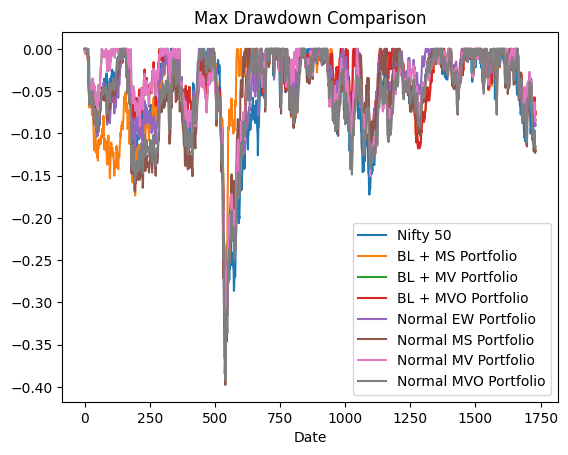

In [195]:
plt.plot(get_max_drawdown(nifty50_portfolio), label="Nifty 50")
plt.plot(get_max_drawdown(portfolio_value_BL_MS), label="BL + MS Portfolio")
plt.plot(get_max_drawdown(portfolio_value_BL_MV), label="BL + MV Portfolio")
plt.plot(get_max_drawdown(portfolio_value_BL_MVO), label="BL + MVO Portfolio")
plt.plot(get_max_drawdown(portfolio_value_normal_ew), label="Normal EW Portfolio")
plt.plot(get_max_drawdown(portfolio_value_normal_ms), label="Normal MS Portfolio")
plt.plot(get_max_drawdown(portfolio_value_normal_mv), label="Normal MV Portfolio")
plt.plot(get_max_drawdown(portfolio_value_normal_mvo), label="Normal MVO Portfolio")

plt.title("Max Drawdown Comparison")
plt.xlabel("Date")
plt.legend()

In [39]:
calculate_yearly_metrics(portfolio_value_BL_MVO, dates_BL_MVO)

,Annual Return (%),Sharpe Ratio,Sortino Ratio,Max Drawdown (%),Volatility (%)
Year,,,,,
2018,18.703689,0.705033,1.036949,-15.132612,18.018580
2019,24.086249,0.980366,1.744238,-9.805141,18.448462
2020,50.270660,1.305364,1.634456,-29.029700,33.914406
2021,15.973254,0.544562,0.866601,-10.523542,18.314278
2022,-13.557017,-0.786854,-1.123508,-27.532660,24.854710
2023,6.849010,0.046945,0.062668,-16.800487,18.085083
2024,7.490594,0.081926,0.135406,-12.945367,18.194496


In [40]:
calculate_yearly_metrics(portfolio_value_normal_mvo, dates_normal_mvo)

,Annual Return (%),Sharpe Ratio,Sortino Ratio,Max Drawdown (%),Volatility (%)
Year,,,,,
2018,12.193569,0.367030,0.537754,-15.759243,16.874852
2019,20.711066,0.865052,1.691903,-12.643257,17.005994
2020,15.971597,0.284351,0.339305,-40.661831,35.067930
2021,21.600009,0.917408,1.444111,-10.614150,17.004446
2022,-4.681517,-0.538142,-0.798105,-17.923893,19.848867
2023,8.284542,0.173506,0.270235,-11.115676,13.166909
2024,4.504987,-0.097131,-0.137423,-9.265872,15.391669
2025,-30.166747,-1.747589,-10.618059,-2.764542,20.695226


In [2]:
# calculate_yearly_metrics(portfolio_value_normal_ew, dates_normal_ew)

In [1]:
# calculate_yearly_metrics(portfolio_value_normal_mvo, dates_normal_mvo)

In [111]:
calculate_yearly_metrics(portfolio_value_BL_MV, dates_BL_MV)

,Annual Return (%),Sharpe Ratio,Sortino Ratio,Max Drawdown (%),Volatility (%)
Year,,,,,
2018,10.134482,0.370888,0.561045,-9.088255,11.147530
2019,8.200818,0.196573,0.326297,-9.814098,11.195954
2020,22.707147,0.641544,0.713447,-32.500659,26.042089
2021,34.270727,1.919434,2.966222,-7.563677,14.728680
2022,-1.062923,-0.461127,-0.678978,-14.998743,15.316642
2023,27.576843,2.189766,3.750229,-6.611188,9.853490
2024,18.175852,0.859382,1.170484,-8.778509,14.168151
2025,-39.137999,-2.953271,-4.255071,-2.421011,15.284071


In [124]:
calculate_yearly_metrics(portfolio_value_normal_ms, dates_normal_ms)

,Annual Return (%),Sharpe Ratio,Sortino Ratio,Max Drawdown (%),Volatility (%)
Year,,,,,
2018,-0.782072,-0.485980,-0.688453,-16.472100,13.955462
2019,14.024977,0.564221,1.031857,-11.881630,14.223114
2020,25.368569,0.613000,0.687536,-39.428106,31.596368
2021,32.823164,1.584990,2.239873,-10.256521,16.923234
2022,4.763922,-0.069089,-0.100250,-12.075639,17.891144
2023,26.453651,1.859354,3.073292,-7.759645,11.000409
2024,15.767000,0.541427,0.630180,-11.924664,18.039377
2025,-37.756295,-2.488017,-4.048044,-2.433347,17.586817


In [113]:
calculate_yearly_metrics(portfolio_value_normal_mv, dates_normal_mv)

,Annual Return (%),Sharpe Ratio,Sortino Ratio,Max Drawdown (%),Volatility (%)
Year,,,,,
2018,10.178120,0.374810,0.567621,-9.056410,11.147310
2019,8.207683,0.197073,0.327213,-9.823354,11.202365
2020,22.714772,0.641640,0.713770,-32.490375,26.050063
2021,34.238097,1.916269,2.962529,-7.545375,14.735975
2022,-1.121005,-0.464764,-0.684782,-15.026283,15.321752
2023,27.524535,2.182339,3.739136,-6.597144,9.863060
2024,18.167167,0.859647,1.173625,-8.778021,14.153673
2025,-39.074902,-2.948863,-4.269339,-2.423997,15.285520


In [101]:
print('done')

done


In [2]:
# # save the lists in a folder called weights
# import os
# import pickle
# if not os.path.exists("weights"):
#     os.makedirs("weights")

# # portfolio_value_BL_MS, dates_BL_MS, W_BL_MS = backtest(max_sharpe_ratio)
# # portfolio_value_BL_MV, dates_BL_MV, W_BL_MV = backtest(min_volatility_weights)

# with open("weights/portfolio_value_BL_MS.pkl", "wb") as f:
#     pickle.dump(portfolio_value_BL_MS, f)
# with open("weights/dates_BL_MS.pkl", "wb") as f:
#     pickle.dump(dates_BL_MS, f)
# with open("weights/W_BL_MS.pkl", "wb") as f:
#     pickle.dump(W_BL_MS, f)
# with open("weights/portfolio_value_BL_MV.pkl", "wb") as f:
#     pickle.dump(portfolio_value_BL_MV, f)
# with open("weights/dates_BL_MV.pkl", "wb") as f:
#     pickle.dump(dates_BL_MV, f)
# with open("weights/W_BL_MV.pkl", "wb") as f:
#     pickle.dump(W_BL_MV, f)


# # import the weights from the folder



In [ ]:
import os
import pickle

with open("weights/dates_BL_MS.pkl", "rb") as f:
    dates_BL_MS = pickle.load(f)
with open("weights/W_BL_MS.pkl", "rb") as f:
    W_BL_MS = pickle.load(f)
with open("weights/portfolio_value_BL_MV.pkl", "rb") as f:
    portfolio_value_BL_MV = pickle.load(f)
with open("weights/dates_BL_MV.pkl", "rb") as f:
    dates_BL_MV = pickle.load(f)
with open("weights/W_BL_MV.pkl", "rb") as f:
    W_BL_MV = pickle.load(f)

In [3]:
import os

file_path = "weights/portfolio_value_BL_MS.pkl"
print("File size (bytes):", os.path.getsize(file_path))


File size (bytes): 32994


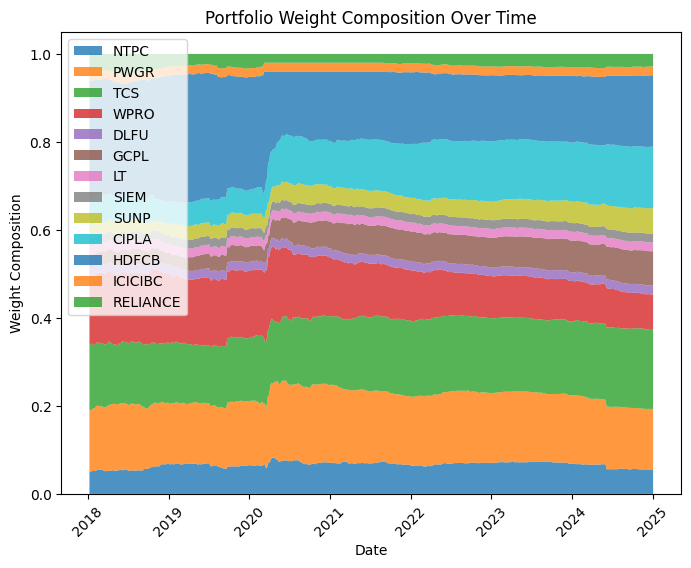

In [212]:
import pandas as pd
df = pd.DataFrame(W_BL_MV, index=dates_BL_MV[::3][:-1])
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6))
ax.stackplot(df.index, df.T, labels=df.columns, alpha=0.8)

# Formatting
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))  # Format dates
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Show every month
plt.xticks(rotation=45)
plt.ylabel("Weight Composition")
plt.xlabel("Date")
plt.legend(loc="upper left")
plt.title("Portfolio Weight Composition Over Time")

plt.show()

In [77]:
import os
import pandas as pd
file_path = "weights/W_BL_MV.pkl"
print("File size (bytes):", os.path.getsize(file_path))

# get the weights from the file
W_BL_MS = pd.read_pickle("weights/W_BL_MS.pkl")
dates_BL_MS = pd.read_pickle("weights/dates_BL_MS.pkl")
portfolio_value_BL_MS = pd.read_pickle("weights/portfolio_value_BL_MS.pkl")

dates_BL_MV = pd.read_pickle("weights/dates_BL_MV.pkl")
W_BL_MV = pd.read_pickle("weights/W_BL_MV.pkl")
portfolio_value_BL_MV = pd.read_pickle("weights/portfolio_value_BL_MV.pkl")

File size (bytes): 86674


In [213]:
with open("final_weights/portfolio_value_BL_MV.pkl", "wb") as f:
    pickle.dump(portfolio_value_BL_MV, f)
with open("final_weights/dates_BL_MV.pkl", "wb") as f:
    pickle.dump(dates_BL_MV, f)
with open("final_weights/W_BL_MV.pkl", "wb") as f:
    pickle.dump(W_BL_MV, f)

In [206]:
# save the weights in a folder called final_weights
import os
import pickle
if not os.path.exists("final_weights"):
    os.makedirs("final_weights")

# save the weights in the folder

# for BL+MS
with open("final_weights/portfolio_value_BL_MS.pkl", "wb") as f:
    pickle.dump(portfolio_value_BL_MS, f)
with open("final_weights/dates_BL_MS.pkl", "wb") as f:
    pickle.dump(dates_BL_MS, f)
with open("final_weights/W_BL_MS.pkl", "wb") as f:
    pickle.dump(W_BL_MS, f)

# for BL+MV
with open("final_weights/portfolio_value_BL_MV.pkl", "wb") as f:
    pickle.dump(portfolio_value_BL_MV, f)
with open("final_weights/dates_BL_MV.pkl", "wb") as f:
    pickle.dump(dates_BL_MV, f)
with open("final_weights/W_BL_MV.pkl", "wb") as f:
    pickle.dump(W_BL_MV, f)

# for BL+MVO
with open("final_weights/portfolio_value_BL_MVO.pkl", "wb") as f:
    pickle.dump(portfolio_value_BL_MVO, f)
with open("final_weights/dates_BL_MVO.pkl", "wb") as f:
    pickle.dump(dates_BL_MVO, f)
with open("final_weights/W_BL_MVO.pkl", "wb") as f:
    pickle.dump(W_BL_MVO, f)


# for normal EW
with open("final_weights/portfolio_value_normal_ew.pkl", "wb") as f:
    pickle.dump(portfolio_value_normal_ew, f)
with open("final_weights/dates_normal_ew.pkl", "wb") as f:
    pickle.dump(dates_normal_ew, f)
with open("final_weights/W_normal_ew.pkl", "wb") as f:
    pickle.dump(W_normal_ew, f)

# for normal MS
with open("final_weights/portfolio_value_normal_ms.pkl", "wb") as f:
    pickle.dump(portfolio_value_normal_ms, f)
with open("final_weights/dates_normal_ms.pkl", "wb") as f:
    pickle.dump(dates_normal_ms, f)
with open("final_weights/W_normal_ms.pkl", "wb") as f:
    pickle.dump(W_normal_ms, f)

# for normal MV
with open("final_weights/portfolio_value_normal_mv.pkl", "wb") as f:
    pickle.dump(portfolio_value_normal_mv, f)
with open("final_weights/dates_normal_mv.pkl", "wb") as f:
    pickle.dump(dates_normal_mv, f)
with open("final_weights/W_normal_mv.pkl", "wb") as f:
    pickle.dump(W_normal_mv, f)

# for normal MVO
with open("final_weights/portfolio_value_normal_mvo.pkl", "wb") as f:
    pickle.dump(portfolio_value_normal_mvo, f)
with open("final_weights/dates_normal_mvo.pkl", "wb") as f:
    pickle.dump(dates_normal_mvo, f)
with open("final_weights/W_normal_mvo.pkl", "wb") as f:
    pickle.dump(W_normal_mvo, f)

# for nifty 50
with open("final_weights/portfolio_value_nifty50.pkl", "wb") as f:
    pickle.dump(nifty50_portfolio, f)
with open("final_weights/dates_nifty50.pkl", "wb") as f:
    pickle.dump(nifty50_dates, f)





In [16]:
import pickle
with open("final_weights/portfolio_value_normal_mv.pkl", "wb") as f:
    pickle.dump(portfolio_value_normal_mv, f)
with open("final_weights/dates_normal_mv.pkl", "wb") as f:
    pickle.dump(dates_normal_mv, f)
with open("final_weights/W_normal_mv.pkl", "wb") as f:
    pickle.dump(W_normal_mv, f)
